In [69]:
## Graphics plots
library(FactoMineR)
library(ggplot2)
library(ggrepel)

## Differential analysis
library(edgeR)
library(limma)

## General data manipulation
library(tidyr)
library(dplyr)


library(DESeq2)
library(stringr)
library(tximport)
library(MASS)


library(PoiClaClu)
library(RColorBrewer)
library(pheatmap)
library(umap)

Warning message:
"le package 'ggrepel' a été compilé avec la version R 4.2.3"


# Load data

In [28]:
txi <- readRDS("txi.rds")
dim(txi$counts)

[1] 62710    15

## Design

In [29]:
### experimental design
condition <- as.factor(c(rep(c("prolif","diff"),7),"diff"))
population <- as.factor(c(rep(c("BT1","BT2","BT54","BT88","LGG275","LGG336","LGG349"),each=2)))
expdes <- data.frame(condition)
#expdes <- data.frame(condition, population)
rownames(expdes) <- colnames(txi$counts)

## put prolif as the reference level
expdes$condition = relevel( expdes$condition, "prolif")
expdes$condition
#expdes$population

(expdes)
dim(expdes)

[1] prolif diff   prolif diff   prolif diff   prolif diff   prolif diff  
[11] prolif diff   prolif diff   diff  
Levels: prolif diff

,condition
,<fct>
BT1_GF,prolif
BT1_noGF,diff
BT2_GF,prolif
BT2_noGF,diff
BT54_GF,prolif
BT54_noGF,diff
BT88_GF,prolif
BT88_noGF,diff
LGG275_GF,prolif


[1] 15  1

# object deseq2

## Before cleaning

In [30]:
dds_before = DESeqDataSetFromTximport(txi, expdes, ~ condition)
dds_before <- dds_before[, which(! rownames(colData(dds_before)) == "LGG85_noGF")] ## for the moment don't analyze LGG85


using just counts from tximport



In [32]:
colData(dds_before)$population <- population
colData(dds_before)$condition <- condition[1:14] ## take off LGG85
design(dds_before) <- ~ condition + population

In [33]:
#Run the analyse
dds_before = DESeq(dds_before)
#Get the results
res_before = results(dds_before)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



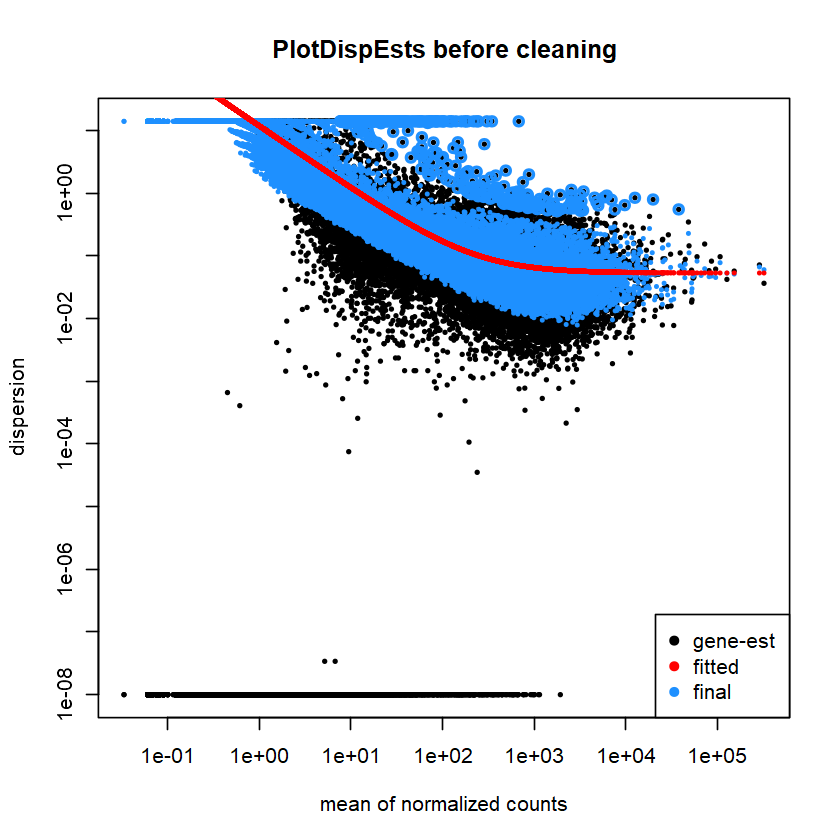

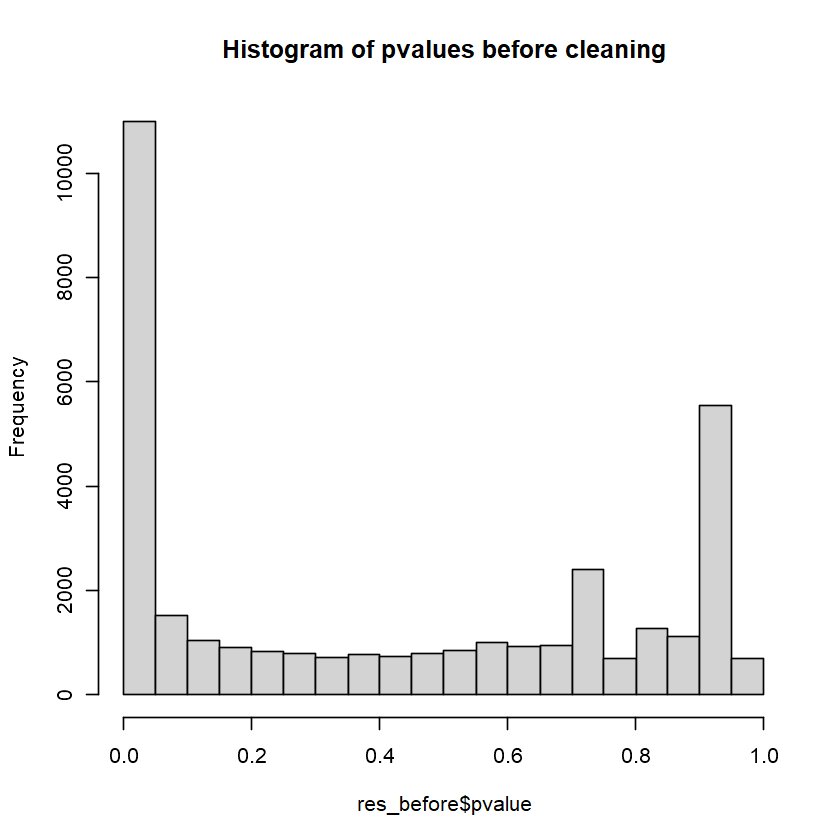

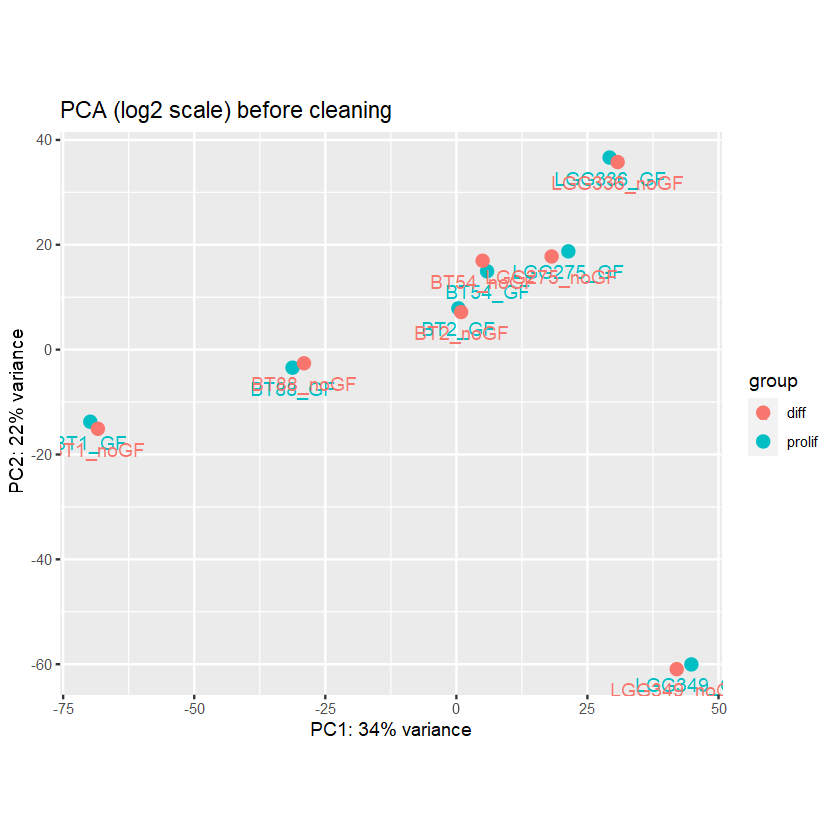

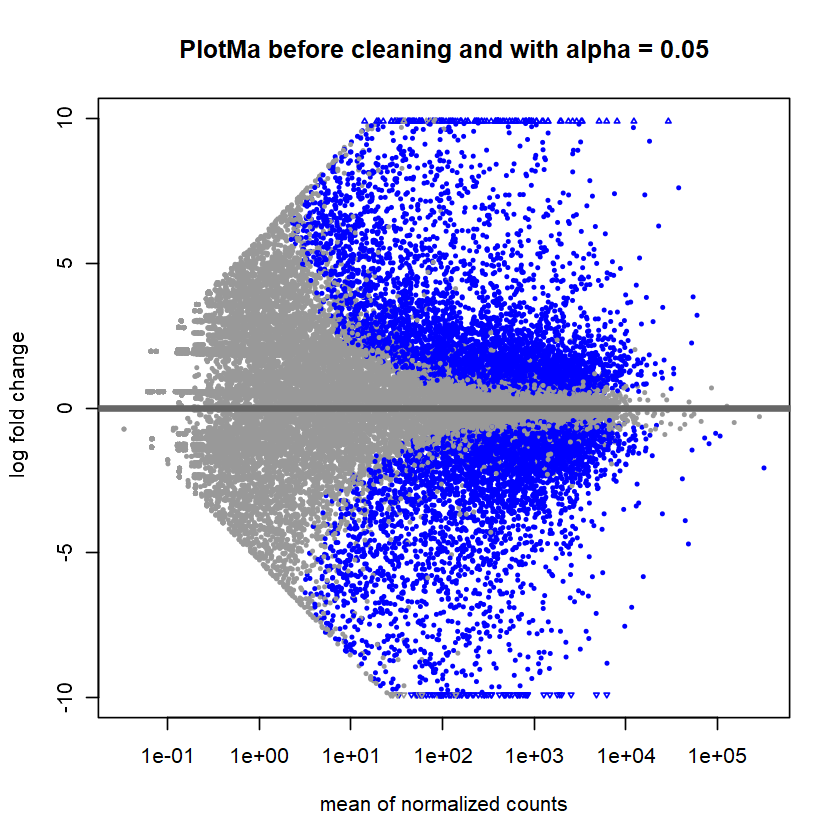

In [34]:
plotDispEsts(dds_before, main="PlotDispEsts before cleaning")
hist(res_before$pvalue, main='Histogram of pvalues before cleaning')
#Perform a log transformation to the data
rld_before = rlog(dds_before)
#Plot the PCA 
plotPCA(rld_before, intgroup=c("condition")) + geom_text(aes(label=name),vjust=2) + ggtitle("PCA (log2 scale) before cleaning")

#Plot MA
plotMA(res_before, main='PlotMa before cleaning and with alpha = 0.05',alpha=0.05)

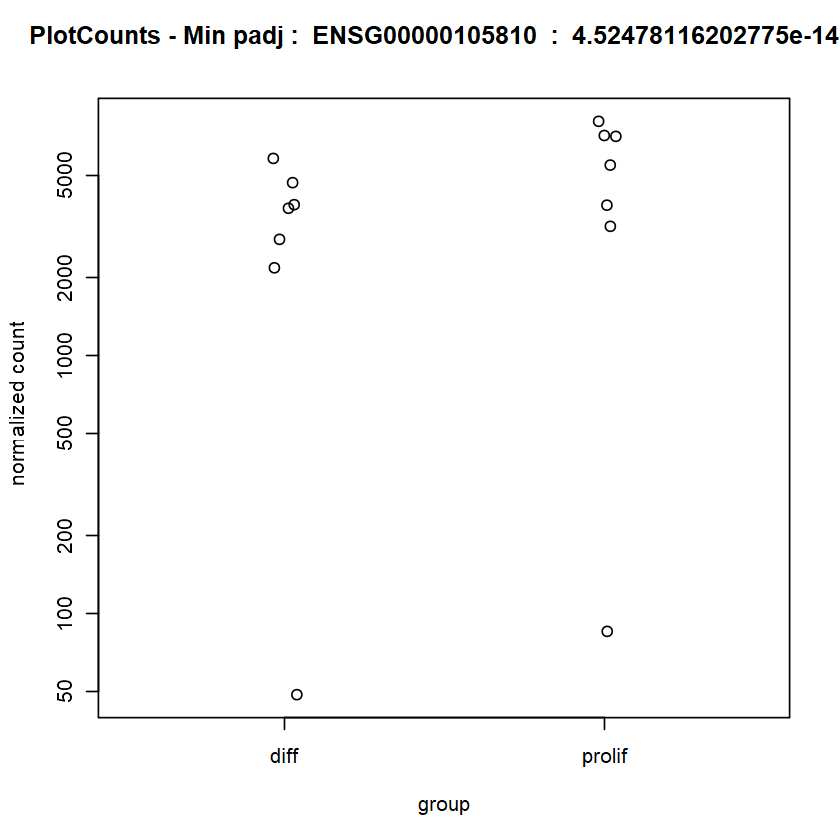

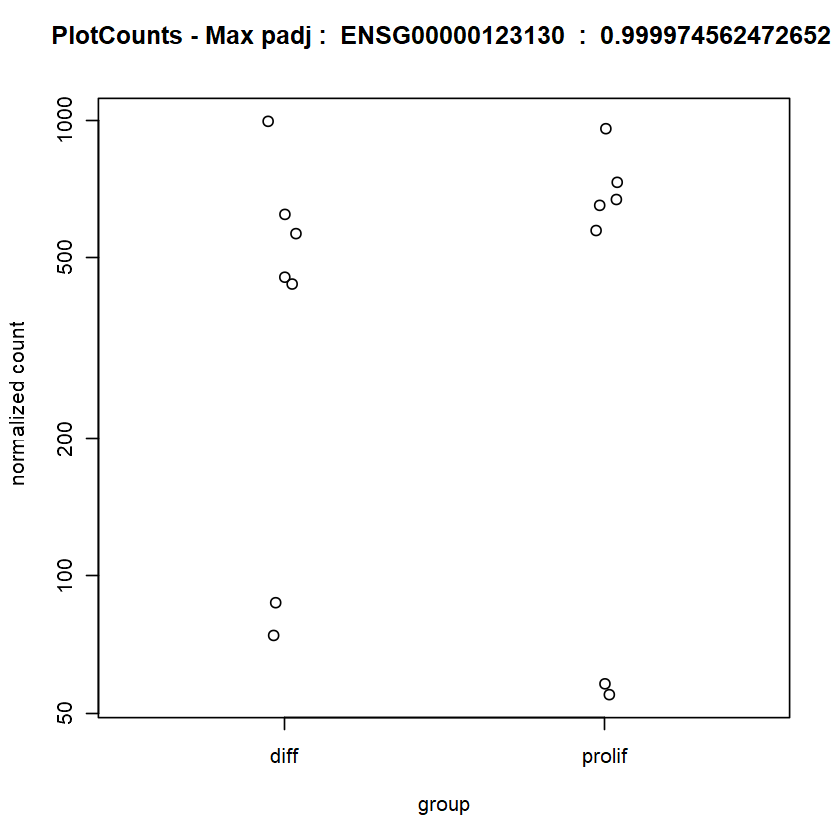

In [35]:
#PlotCounts for the gene with the smallest p-value
title = paste("PlotCounts - Min padj : ", row.names(res_before[which.min(res_before$padj),]), " : ", res_before[which.min(res_before$padj),]$padj, '\n')
plotCounts(dds_before,which.min(res_before$padj),intgroup = "condition",  normalized = TRUE, main= title)

#PlotCounts for the gene with the biggest p-value
title = paste("PlotCounts - Max padj : ", row.names(res_before[which.max(res_before$padj),]), " : ", res_before[which.max(res_before$padj),]$padj, '\n')
plotCounts(dds_before,which.max(res_before$padj),intgroup = "condition",  normalized = TRUE, main = title)


## Pre filtering

In [36]:
## filter out genes with 10 counts or less
txi$counts = txi$counts[-which(rowSums(txi$counts) <= 10),]
dim(txi$counts)

[1] 25032    15

In [37]:
dds <- DESeqDataSetFromTximport(txi, expdes, ~ condition )
dds <- dds[, which(! rownames(colData(dds)) == "LGG85_noGF")] ## for the moment don't analyze LGG85
dds

using just counts from tximport



class: DESeqDataSet 
dim: 25032 14 
metadata(1): version
assays(1): counts
rownames(25032): ENSG00000000003 ENSG00000000419 ... ENSG00000291316
  ENSG00000291317
rowData names(0):
colnames(14): BT1_GF BT1_noGF ... LGG349_GF LGG349_noGF
colData names(1): condition

In [38]:
colData(dds)$population <- population
colData(dds)$condition <- condition[1:14] ## take off LGG85
design(dds) <- ~ condition + population

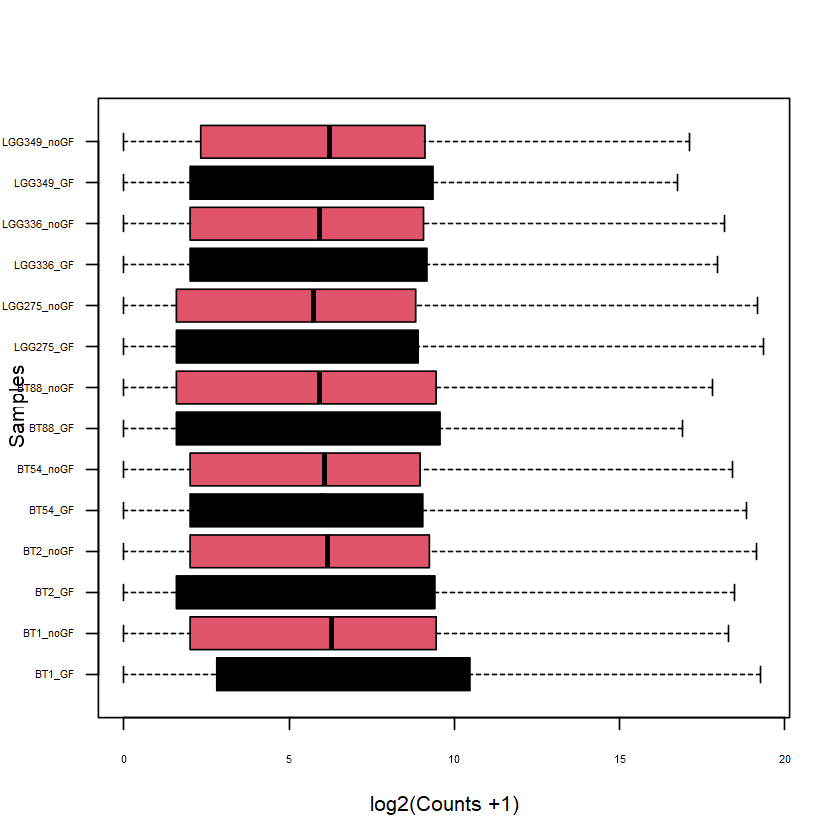

In [39]:
## Boxplots of gene count distributions per sample  (non-normalized log2(counts) per sample.)
count.table <- counts(dds)
epsilon <- 1 # pseudo-count to avoid problems with log(0)
boxplot(log2(count.table + epsilon), col=expdes$condition, pch=".", 
        horizontal=TRUE, cex.axis=0.5,
        las=1, ylab="Samples", xlab="log2(Counts +1)")

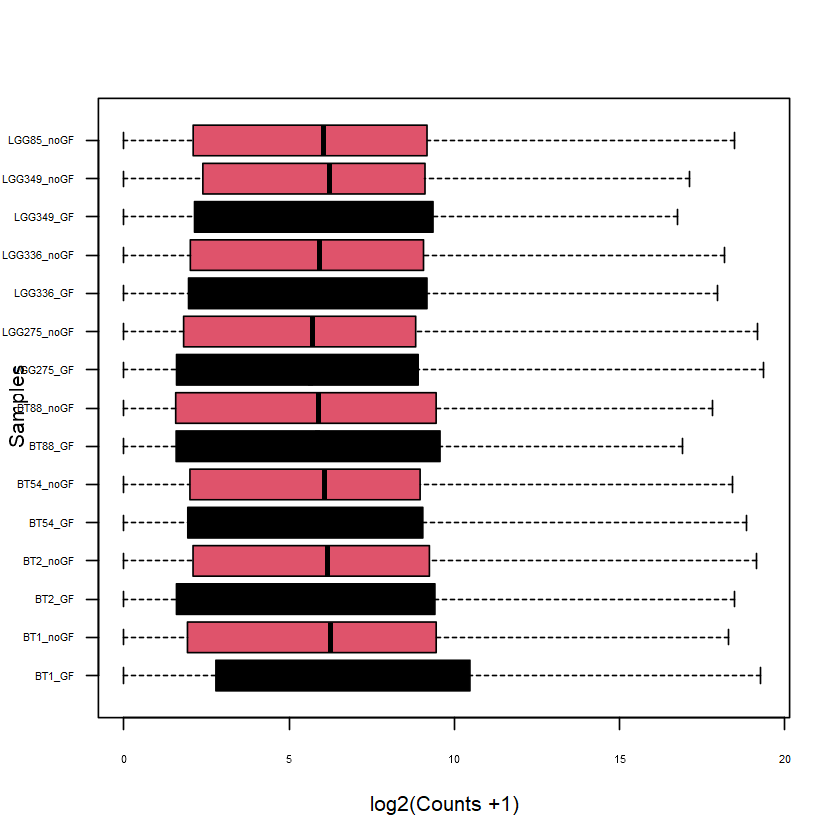

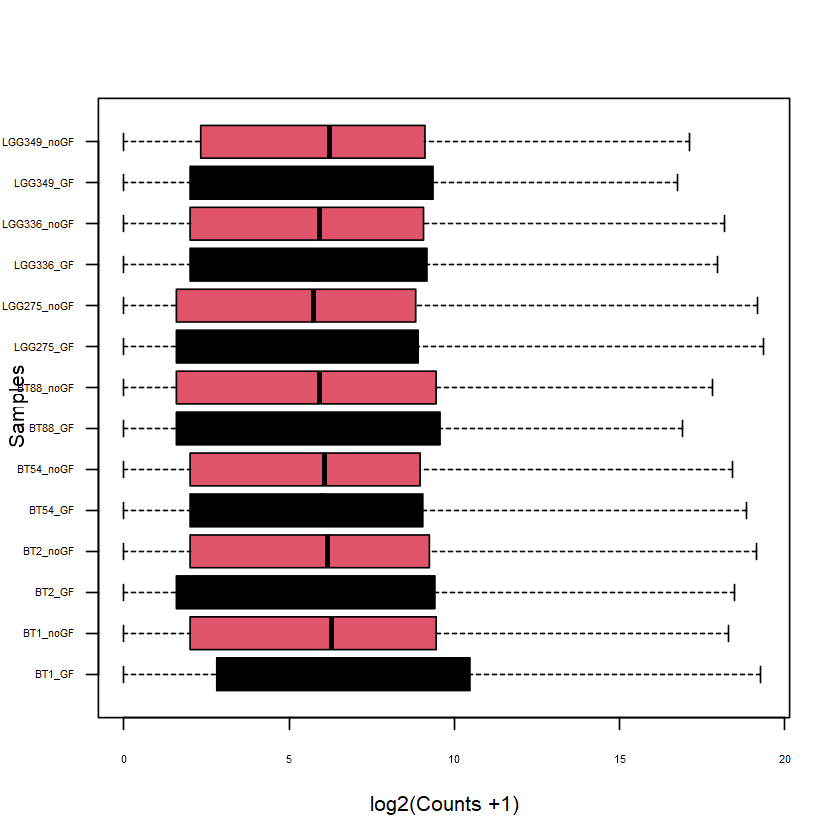

In [40]:
## Boxplots of gene count distributions per sample  (non-normalized log2(counts) per sample.)
count.table <- txi$counts
epsilon <- 1 # pseudo-count to avoid problems with log(0)
boxplot(log2(count.table + epsilon), col=expdes$condition, pch=".", 
        horizontal=TRUE, cex.axis=0.5,
        las=1, ylab="Samples", xlab="log2(Counts +1)")

count.table <- counts(dds)
epsilon <- 1 # pseudo-count to avoid problems with log(0)
boxplot(log2(count.table + epsilon), col=expdes$condition, pch=".", 
        horizontal=TRUE, cex.axis=0.5,
        las=1, ylab="Samples", xlab="log2(Counts +1)")   

# Analyse diff

### population + condition

In [41]:
design(dds) <- ~ population + condition
dds <- DESeq(dds) 

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



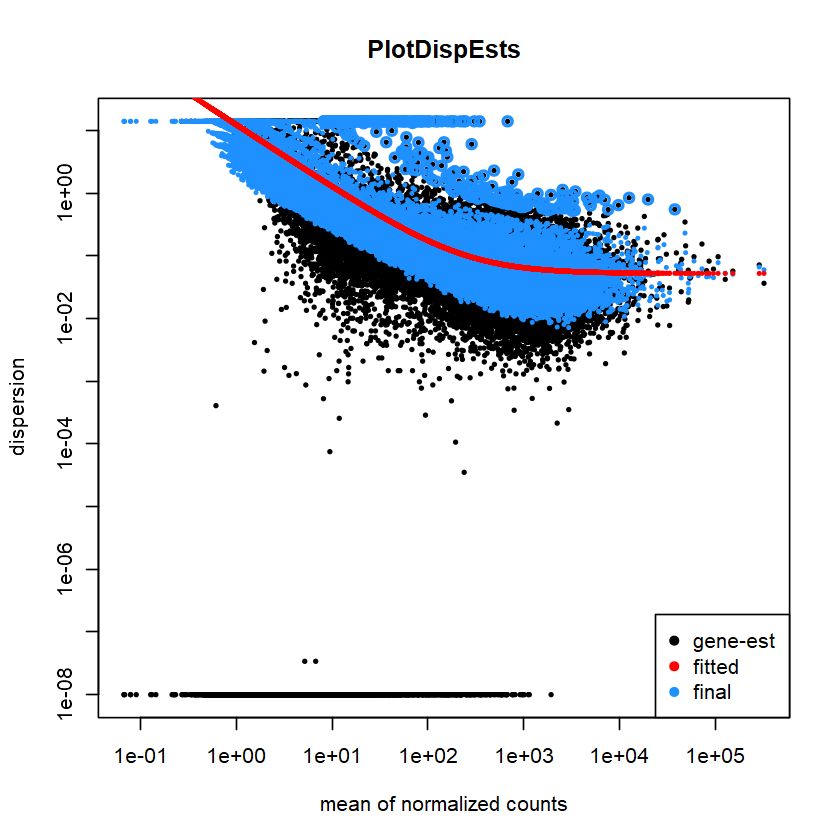

In [42]:
plotDispEsts(dds, main="PlotDispEsts")


out of 25017 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2905, 12%
LFC < 0 (down)     : 3137, 13%
outliers [1]       : 0, 0%
low counts [2]     : 6305, 25%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



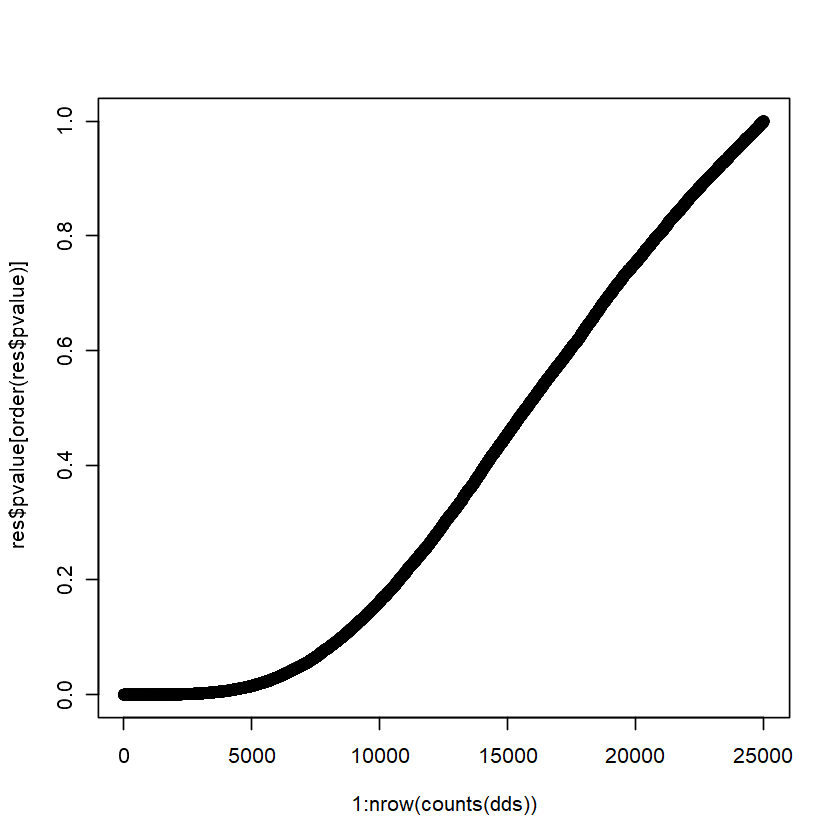

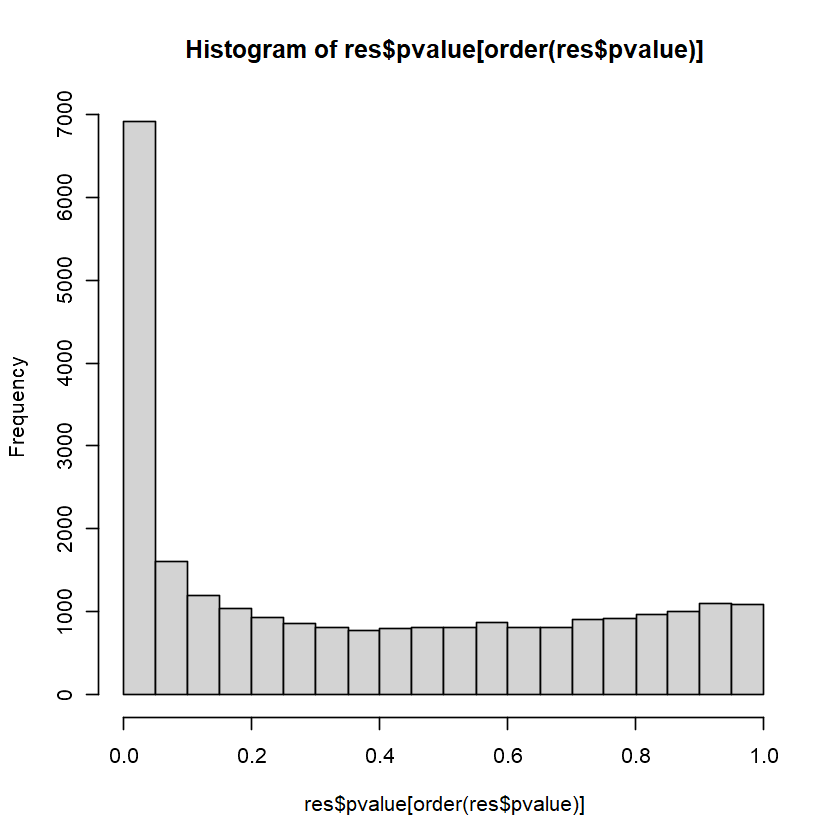

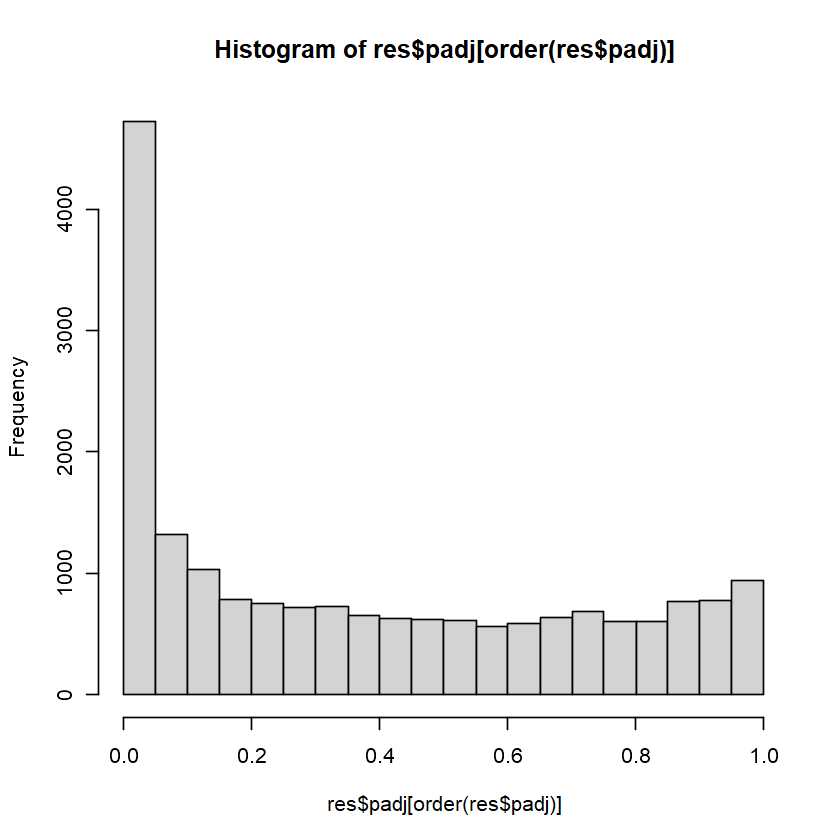

In [43]:
res =  results(dds)
summary(res)
res$pvalue <- res$pvalue[order(res$pvalue)]

plot(1:nrow(counts(dds)), res$pvalue[order(res$pvalue)])
# on ordonne les pvalues par ordre croissant et on affiche un plot des ces pvalues

hist(res$pvalue[order(res$pvalue)])
hist(res$padj[order(res$padj)])

### plots cook

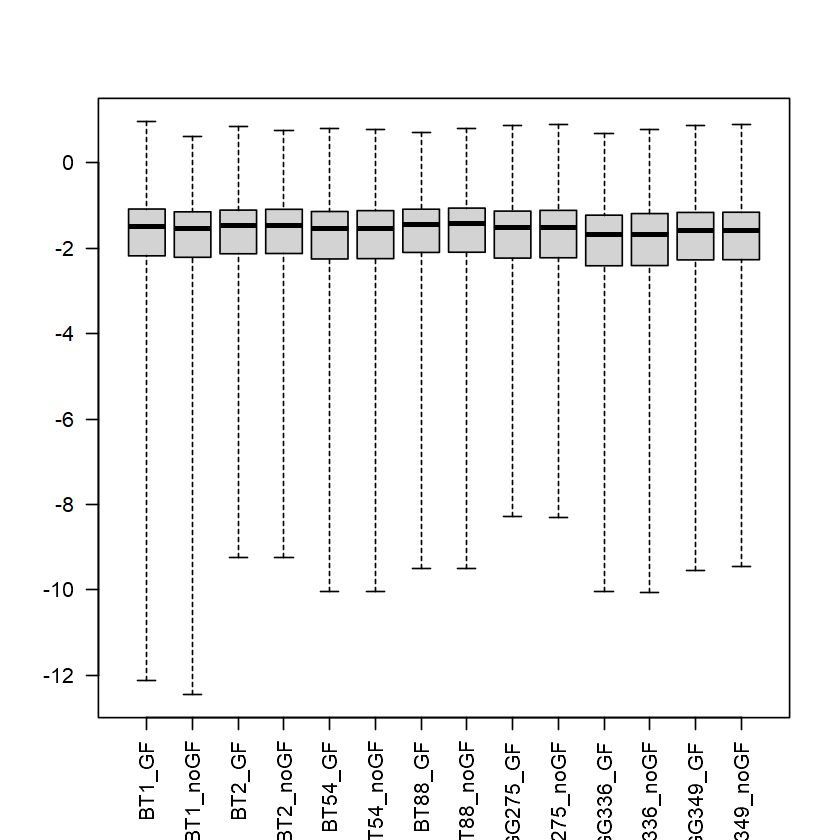

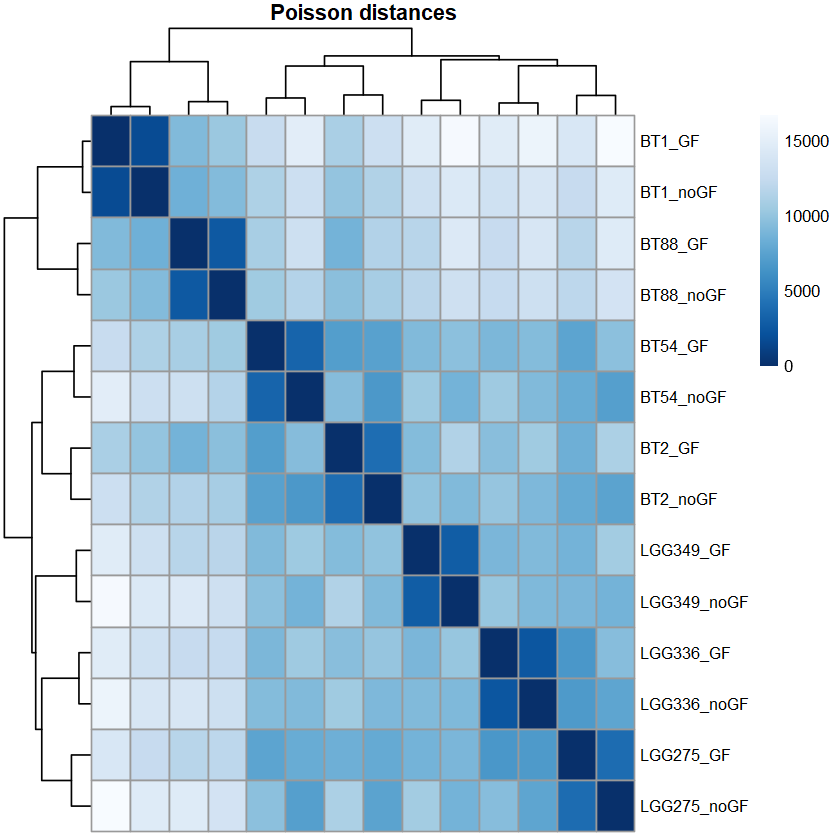

In [44]:
#-----Boxplot of Cooks distances 
boxplot(log10(assays(dds)[["cooks"]]), range=0, las=2)

# Heatmap, Poisson
poisd <- PoissonDistance(t(counts(dds)))
samplePoisDistMatrix <- as.matrix( poisd$dd )
rownames(samplePoisDistMatrix) <- colnames(counts(dds))
colnames(samplePoisDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)

pheatmap(samplePoisDistMatrix,
         clustering_distance_rows = poisd$dd,
         clustering_distance_cols = poisd$dd,
         col = colors,
         main = "Poisson distances")


# Results

In [45]:
resultsNames(dds)

[1] "Intercept"                "population_BT2_vs_BT1"   
[3] "population_BT54_vs_BT1"   "population_BT88_vs_BT1"  
[5] "population_LGG275_vs_BT1" "population_LGG336_vs_BT1"
[7] "population_LGG349_vs_BT1" "condition_prolif_vs_diff"

In [46]:
## Log fold change shrinkage for visualization and ranking
resLFC <- lfcShrink(dds, coef="condition_prolif_vs_diff", type="apeglm")
resLFC

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



log2 fold change (MAP): condition prolif vs diff 
Wald test p-value: condition prolif vs diff 
DataFrame with 25032 rows and 5 columns
                  baseMean log2FoldChange     lfcSE      pvalue       padj
                 <numeric>      <numeric> <numeric>   <numeric>  <numeric>
ENSG00000000003 1040.69476     -0.0543394  0.146441 6.72696e-01 0.80338782
ENSG00000000419  578.50232      0.2639895  0.112978 1.17094e-02 0.04738475
ENSG00000000457  223.83702     -0.1243026  0.150743 3.44677e-01 0.52619305
ENSG00000000460  300.33408      1.1328364  0.282955 2.64872e-06 0.00009166
ENSG00000000938    4.45321     -0.1290195  0.340203 1.24633e-01         NA
...                    ...            ...       ...         ...        ...
ENSG00000291309    2.35802    -0.07695990  0.320496 0.292839938         NA
ENSG00000291313   27.25605     0.02956163  0.313265 0.444373898 0.62138099
ENSG00000291314    1.39701    -0.00692787  0.316254 0.803940896         NA
ENSG00000291316   19.93822    -0.0920681

## pvalue

In [47]:
resOrdered <- res[order(res$pvalue),]
summary(res)


out of 25017 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2905, 12%
LFC < 0 (down)     : 3137, 13%
outliers [1]       : 15, 0.06%
low counts [2]     : 6312, 25%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [48]:
sum(res$padj < 0.1, na.rm=TRUE)

[1] 6042

In [49]:
res05 <- results(dds, alpha=0.05)
summary(res05)


out of 25017 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2350, 9.4%
LFC < 0 (down)     : 2399, 9.6%
outliers [1]       : 0, 0%
low counts [2]     : 6790, 27%
(mean count < 7)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [50]:
sum(res05$padj < 0.05, na.rm=TRUE)


[1] 4749

# plot counts

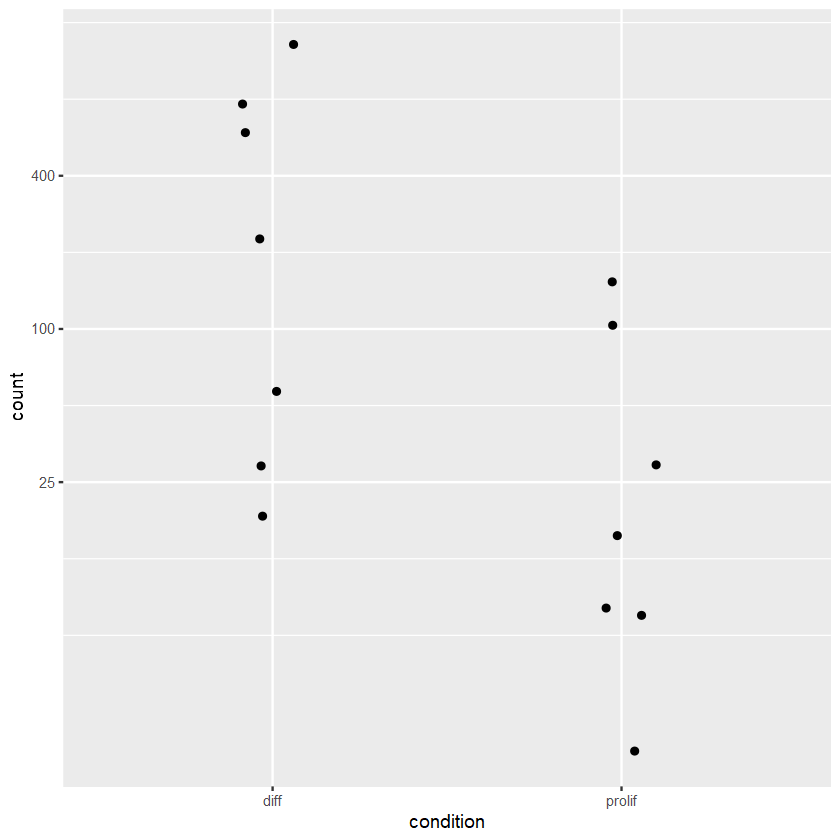

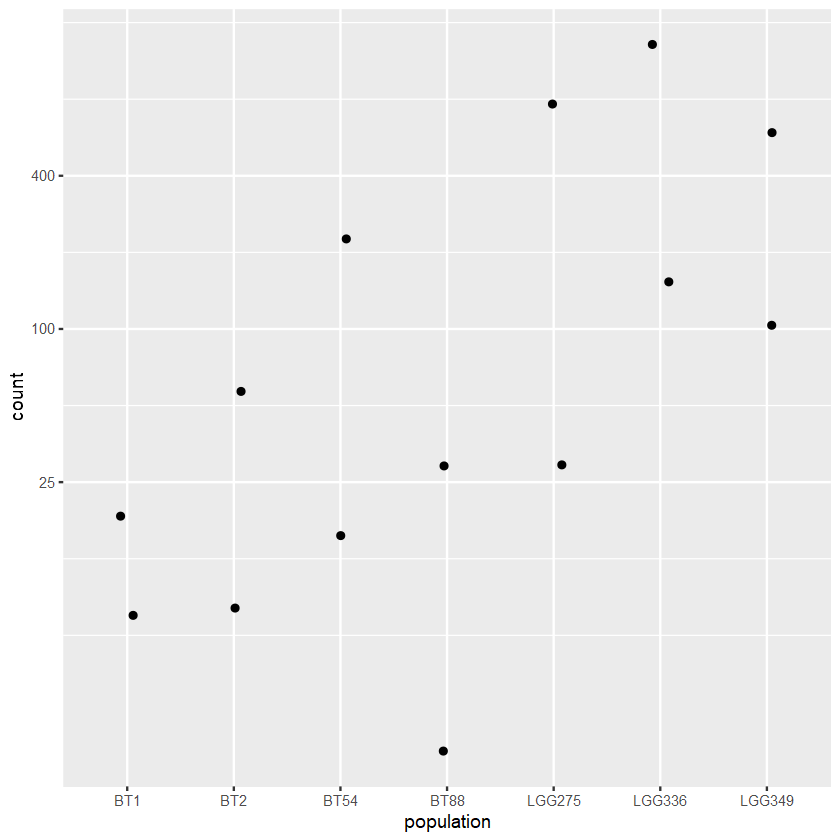

In [51]:
d <- plotCounts(dds, gene=which.min(res$padj), intgroup="condition", 
                returnData=TRUE)
library("ggplot2")
ggplot(d, aes(x=condition, y=count)) + 
  geom_point(position=position_jitter(w=0.1,h=0)) + 
  scale_y_log10(breaks=c(25,100,400))


d <- plotCounts(dds, gene=which.min(res$padj), intgroup="population", 
                returnData=TRUE)
library("ggplot2")
ggplot(d, aes(x=population, y=count)) + 
  geom_point(position=position_jitter(w=0.1,h=0)) + 
  scale_y_log10(breaks=c(25,100,400))


In [52]:
## Extracting transformed values
ntd <- normTransform(dds)
vsd <- vst(dds, blind=FALSE)
rld <- rlog(dds, blind=FALSE)

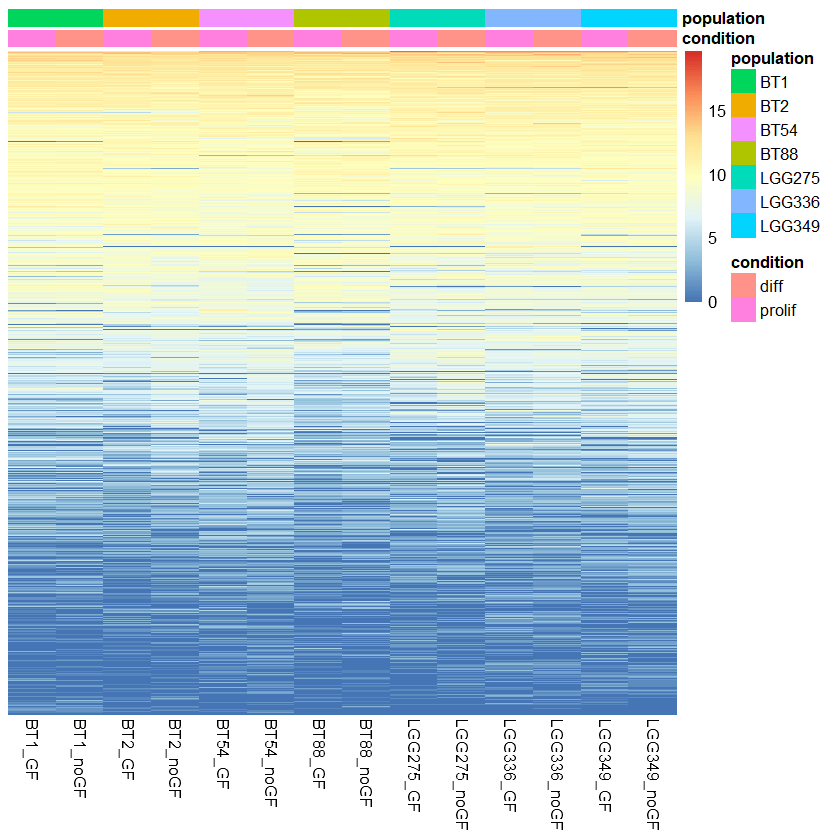

In [53]:
df <- as.data.frame(colData(dds)[,c("condition","population")])
select <- order(rowMeans(counts(dds,normalized=TRUE)),
                decreasing=TRUE)
pheatmap(assay(ntd)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE, annotation_col=df)

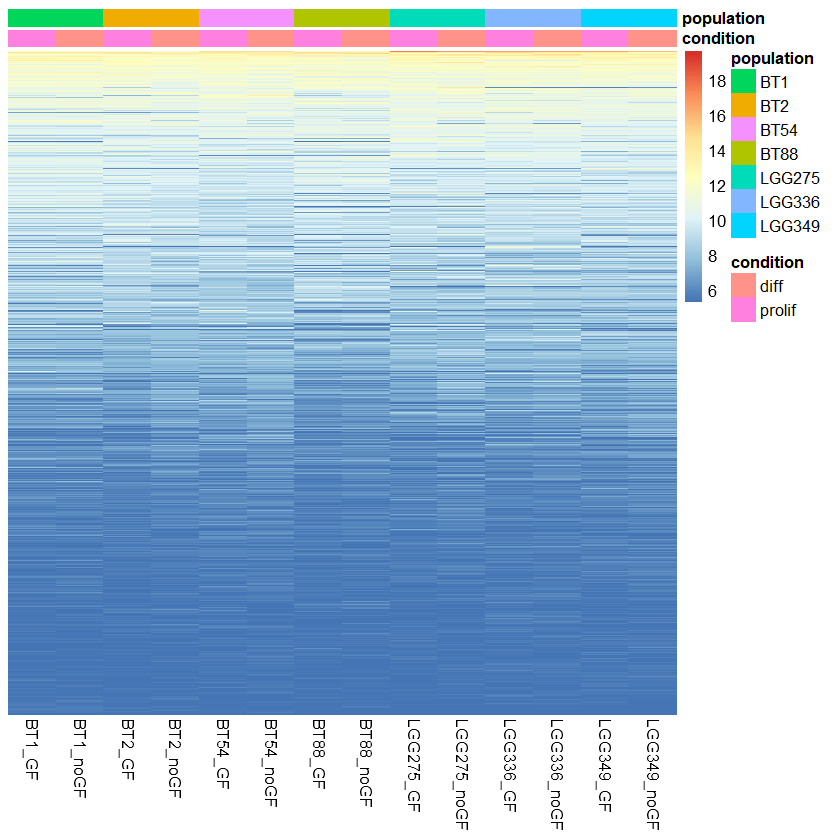

In [54]:
pheatmap(assay(vsd)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE, annotation_col=df)

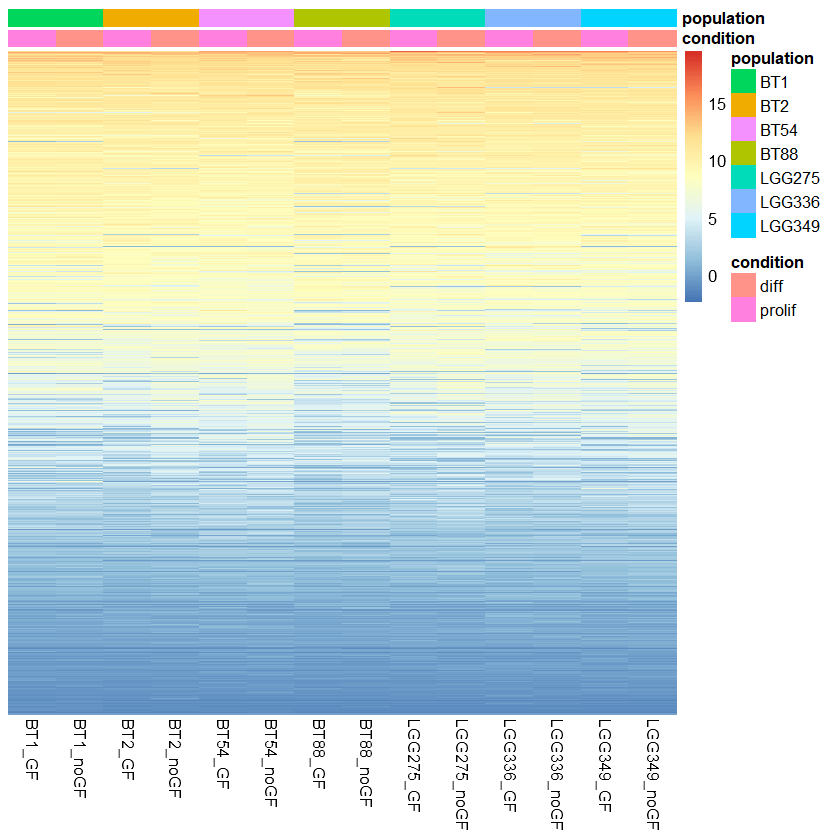

In [55]:
pheatmap(assay(rld)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE, annotation_col=df)

# MA plot

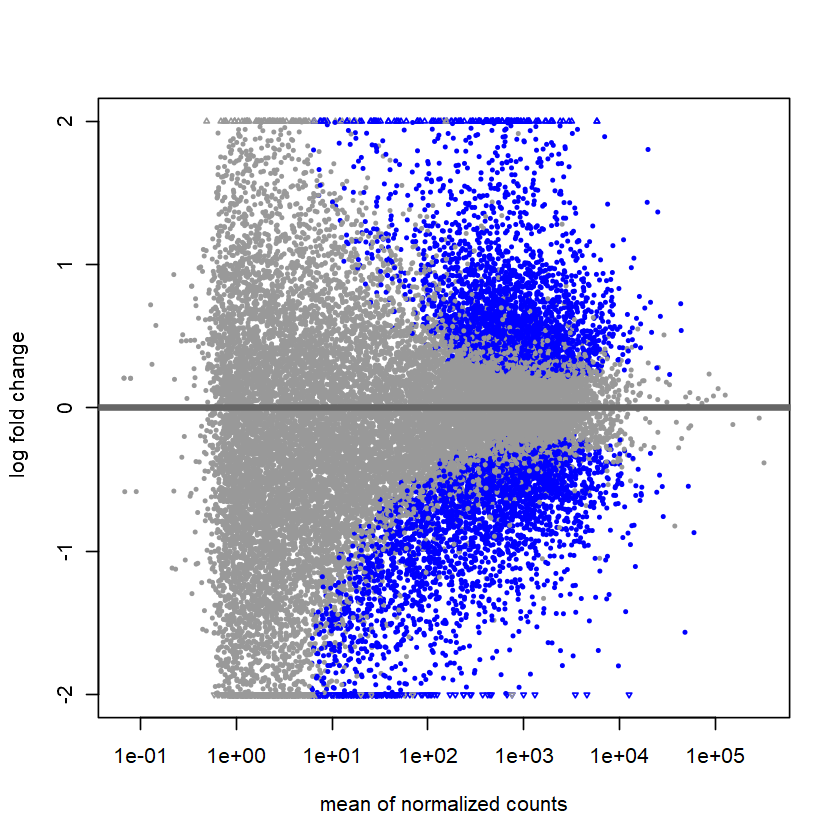

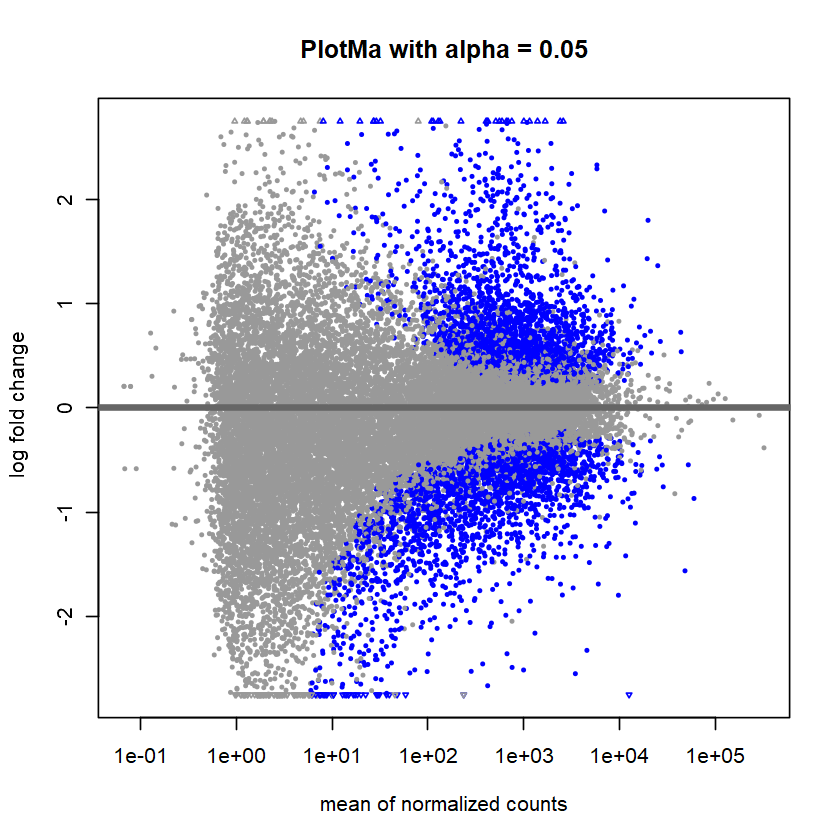

In [56]:
plotMA(res, ylim=c(-2,2))
plotMA(res, main='PlotMa with alpha = 0.05',alpha=0.05)

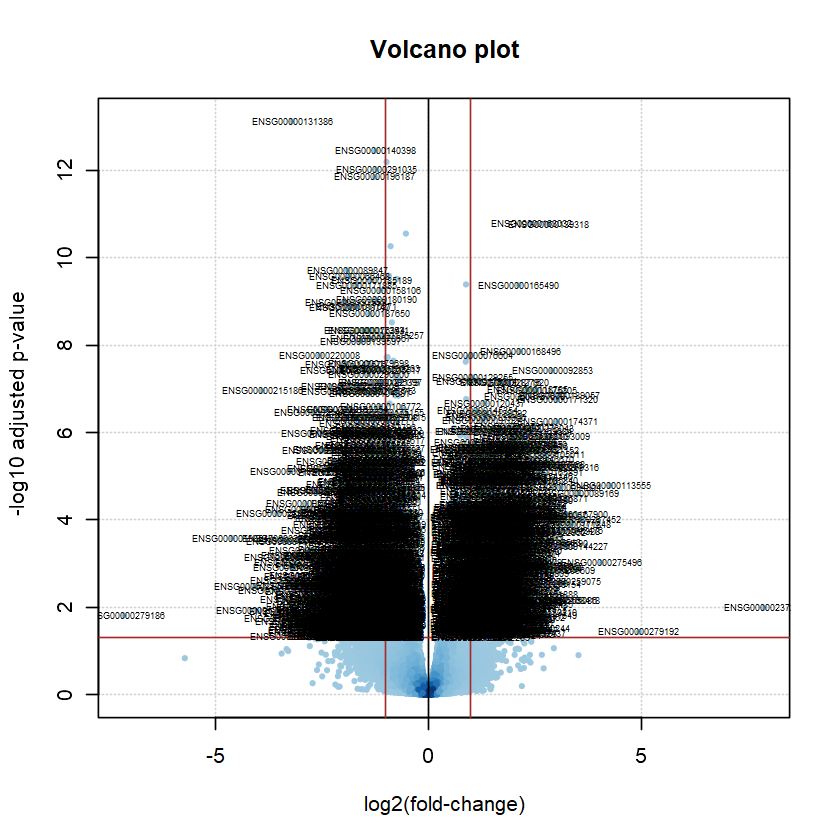

In [57]:
volcano <- function(alpha = 0.05, res) {
  
  colors <- densCols(res$log2FoldChange, -log10(res$padj))
  plot(res$log2FoldChange, -log10(res$padj), col=colors, panel.first=grid(),
       main="Volcano plot", xlab="log2(fold-change)", ylab="-log10 adjusted p-value",
       pch=20, cex=0.6)
  abline(v=0)
  abline(v=c(-1,1), col="brown")
  abline(h=-log10(alpha), col="brown")
  
  de_genes <- abs(res$log2FoldChange) > 1 & res$padj < alpha 
  text(res$log2FoldChange[de_genes],
       -log10(res$padj)[de_genes],
       lab=rownames(res)[de_genes ], cex=0.4)
}
volcano(alpha = 0.05, res)

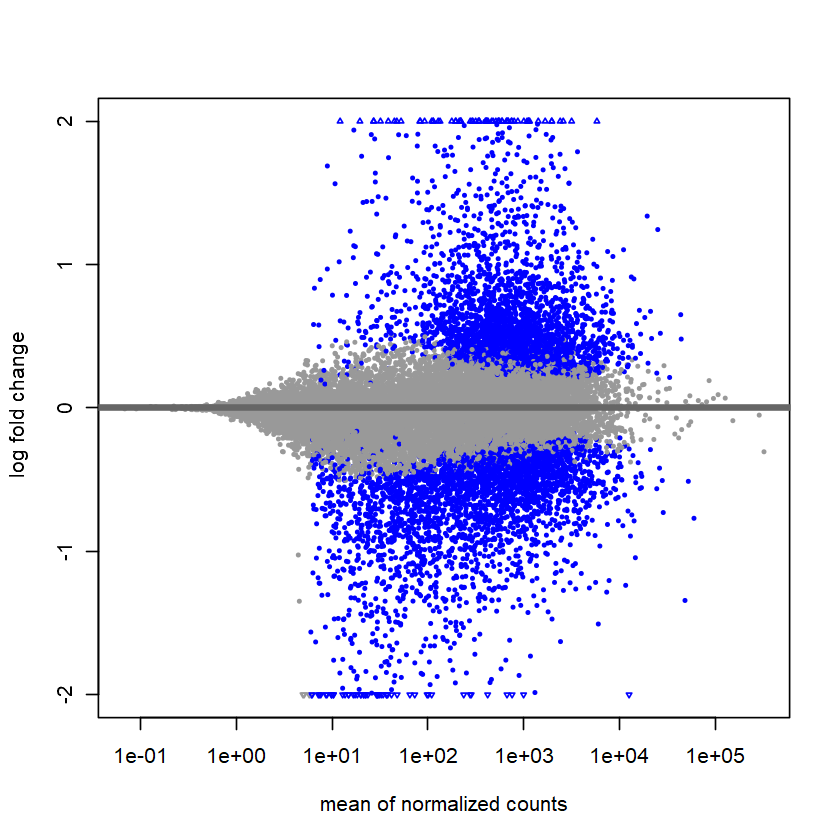

In [58]:
plotMA(resLFC, ylim=c(-2,2))


In [59]:
genes = rownames(res)
de_genes <- abs(res$log2FoldChange) > 1 & res$padj < 0.05 
de_genes = genes[de_genes]
# Some genes do not fall into conditions and thus return NA
de_genes = de_genes[!is.na(de_genes)]
length(de_genes)

[1] 1417

## PCA

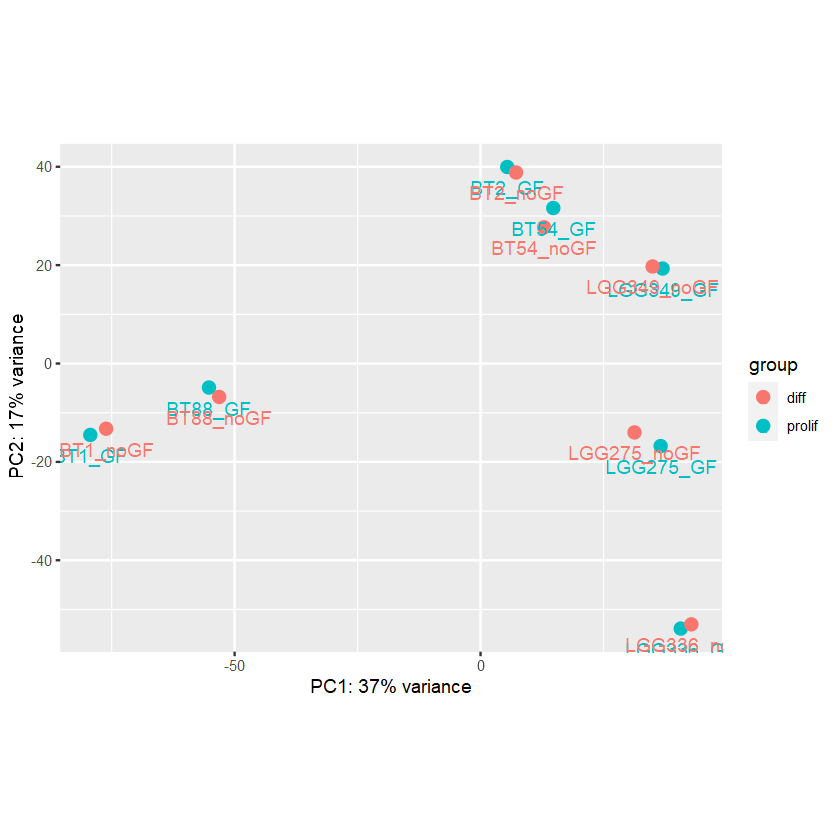

In [60]:
plotPCA(rld, intgroup=c("condition")) + geom_text(aes(label=name),vjust=2) 

# Volcano

In [66]:
resLFC <- as.data.frame(resLFC)
resLFC$diffexpressed <- "NO"
resLFC$diffexpressed[resLFC$log2FoldChange>0.1 & resLFC$padj<0.05] <- "UP"
resLFC$diffexpressed[resLFC$log2FoldChange<0.1 & resLFC$padj<0.05] <- "DOWN"

resLFC$delabel <- NA

In [76]:
length(resLFC$diffexpressed[which(resLFC$diffexpressed == "NO" )])
length(resLFC$diffexpressed[which(resLFC$diffexpressed == "UP" )])
length(resLFC$diffexpressed[which(resLFC$diffexpressed == "DOWN" )])

[1] 20309

[1] 2334

[1] 2389

Warning message:
"Removed 15 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 25032 rows containing missing values (`geom_text_repel()`)."


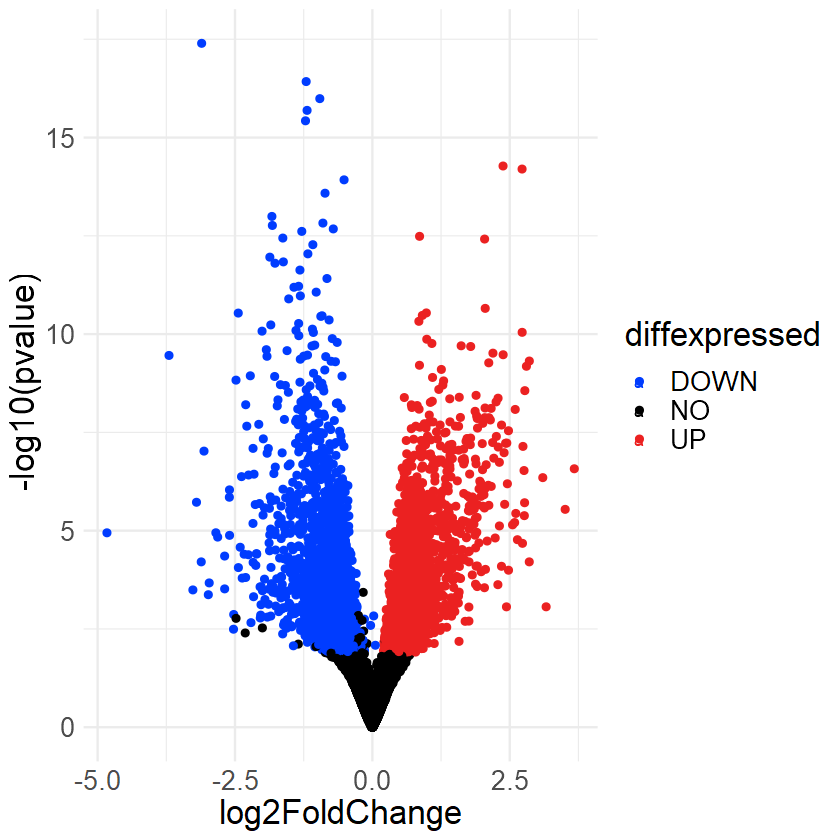

In [74]:
ggplot(data=resLFC, aes(x=log2FoldChange, y=-log10(pvalue), col=diffexpressed, label=delabel)) +
    geom_point()+
    theme_minimal()+
    geom_text_repel()+
    scale_color_manual(values = c('#003cff', 'black', '#eb2121'))+
    theme(text = element_text(size = 20))


# contrast

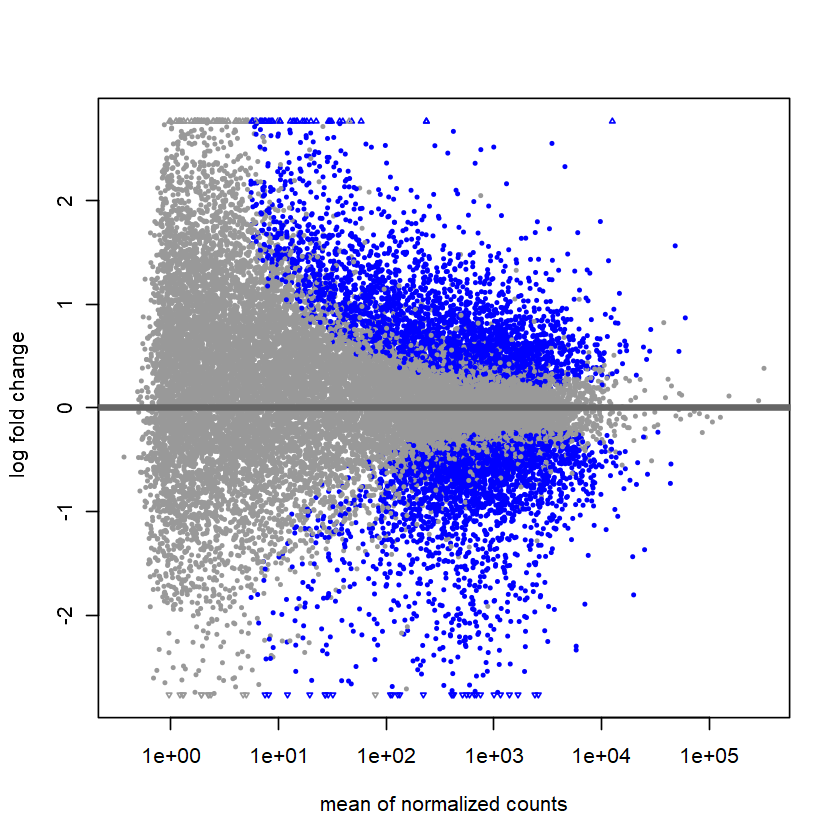

In [ ]:
res <- results(dds, contrast = c("condition", "diff", "prolif"))
plotMA(res)

In [ ]:
resOrdered <- res[order(res$pvalue),]
summary(res)


out of 24658 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 3136, 13%
LFC < 0 (down)     : 2901, 12%
outliers [1]       : 0, 0%
low counts [2]     : 5737, 23%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



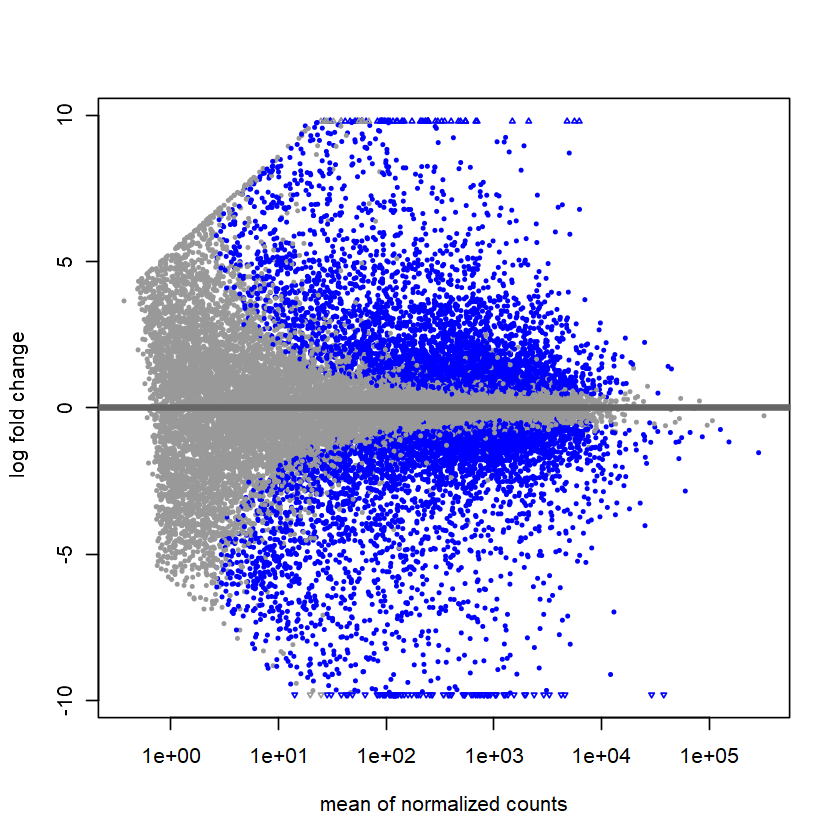

In [ ]:
res <- results(dds, contrast = c("population", "BT1", "BT2"))
plotMA(res)

In [ ]:
idx <- identify(res$baseMean, res$log2FoldChange)
rownames(res)[idx]

ERROR: Error in identify.default(res$baseMean, res$log2FoldChange): plot.new has not been called yet
